# Decoding the belief state from a value RNN

In [1]:
import os
import numpy as np; np.set_printoptions(linewidth=150)
import torch; torch.set_printoptions(linewidth=150)
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
from environment import CliffWalk
from episodes import Episode, collect_episodes, monte_carlo_state_values, episodes_to_batch, episodes_to_masks, extract_monte_carlo_returns, beliefs_to_batch
from belief_decoders import BeliefDecoder, linearBeliefDecoder, train_belief_decoder, plot_decoded_belief

In [3]:
# TD loss function
def td_loss(values, rewards, mask_traj, lengths, gamma=1.0):
    
    # calculate the TD target
    values_next = torch.zeros_like(values)
    values_next[:, :-1] = values[:, 1:]
    for b, l in enumerate(lengths): # TD target at last value should only be the reward
        values_next[b, l-1] = 0.0
    td_target = rewards + (gamma * values_next.detach())
    
    # Calculate the TD error
    td_error = ((values - td_target) ** 2) * mask_traj
    loss = td_error.sum() / mask_traj.sum()  # average loss over non-masked values
    
    return loss


def mc_loss(values, returns, mask_monte_carlo):
    # Compute the mc loss only at start and terminal states
    mc_values = values * mask_monte_carlo
    mc_returns = returns * mask_monte_carlo
    
    # Set first state return to the average of all first states
    start_state_return = mc_returns[:, 0].mean()
    mc_returns[:, 0] = start_state_return  

    mc_error = (mc_values - mc_returns) ** 2

    mc_loss = mc_error.sum() / mask_monte_carlo.sum()  # average loss over non-masked values

    return mc_loss

def evaluate_episode(model, episode):
    model.eval()  # switch to eval mode

    with torch.no_grad():
        history = torch.tensor(episode.history, dtype=torch.float32).unsqueeze(0)  # shape: [1, T, D]
        length = [history.shape[1]]  # length = [T]
        mask = torch.ones((1, history.shape[1]), dtype=torch.float32)

        predicted_values, _ = model(history, mask)  # shape: [1, T]
        return predicted_values.squeeze(0).numpy()  # shape: [T]
    
def validate(model, test_episode, value):
    true_values = test_episode.belief_states @ value
    true_values = np.round(true_values, 2)
    
    values = evaluate_episode(model, test_episode)
    values = np.round(values, 2)

    print("True Values:")
    print(true_values)
    print("Predicted Values:")
    print(values)
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='True Values', marker='o')
    plt.plot(values, label='Predicted Values', marker='x')
    plt.title("True vs Predicted Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()



def save_checkpoint(model, epoch, checkpoint_dir="checkpoints", filename=None):
    os.makedirs(checkpoint_dir, exist_ok=True)
    if filename is None:
        filename = f"checkpoint_epoch_{epoch}.pth"
    path = os.path.join(checkpoint_dir, filename)
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Saved checkpoint: {path}")


In [4]:
# Define the RNN-based value estimator
class ValueRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        # RNN to process the history of observations and actions
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        # Head to output the value for each time step from the RNN output
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x, mask):
        hidden_states, _ = self.rnn(x)  # [B, T, H]
        
        # Calculate the output values for each time step
        values = self.head(hidden_states)  # [B, T, 1]
        values = values.squeeze(-1)  # [B, T]
        values = values * mask  # Apply the mask to the output

        return values, hidden_states
    
# Training loop
def train(model, episodes, test_episode, value=None, num_epochs=10, gamma=1.0, lr=1e-3, validate_every=500, batch_size=32):
    
    histories, rewards = episodes_to_batch(episodes)
    mask, mask_monte_carlo, lengths = episodes_to_masks(episodes)
    mc_returns = extract_monte_carlo_returns(rewards, mask, gamma)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    
    model.train()

    for epoch in range(num_epochs):
        # Validate sometimes
        if (epoch) % validate_every == 0:
            validate(model, test_episode, value)
            save_checkpoint(model, epoch)

        # choose "batch_size" random episodes from the dataset
        indices = np.random.choice(len(episodes), size=min(batch_size, len(episodes)), replace=False)
        batch_lengths = [lengths[i] for i in indices]

        # Calculate the estimated values
        optimizer.zero_grad()
        values, _ = model(histories[indices], mask[indices])  # shape: [B, T]
        
        # Calculate losses, and combine them
        td_L = td_loss(values, rewards[indices], mask[indices], batch_lengths, gamma)
        mc_L = mc_loss(values, mc_returns[indices], mask_monte_carlo[indices])
        loss = td_L + mc_L 
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print losses
        print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}     ", end= '\r')
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}")
        

## Collect Data

Empirical Value function:
[[-18.93 -17.33 -15.74 -14.16 -12.41 -10.68  -8.39  -5.56]
 [-17.55 -15.76 -14.35 -12.93 -11.44  -9.81  -7.56  -3.11]
 [-18.34 -10.   -10.   -10.   -10.   -10.   -10.     0.  ]]


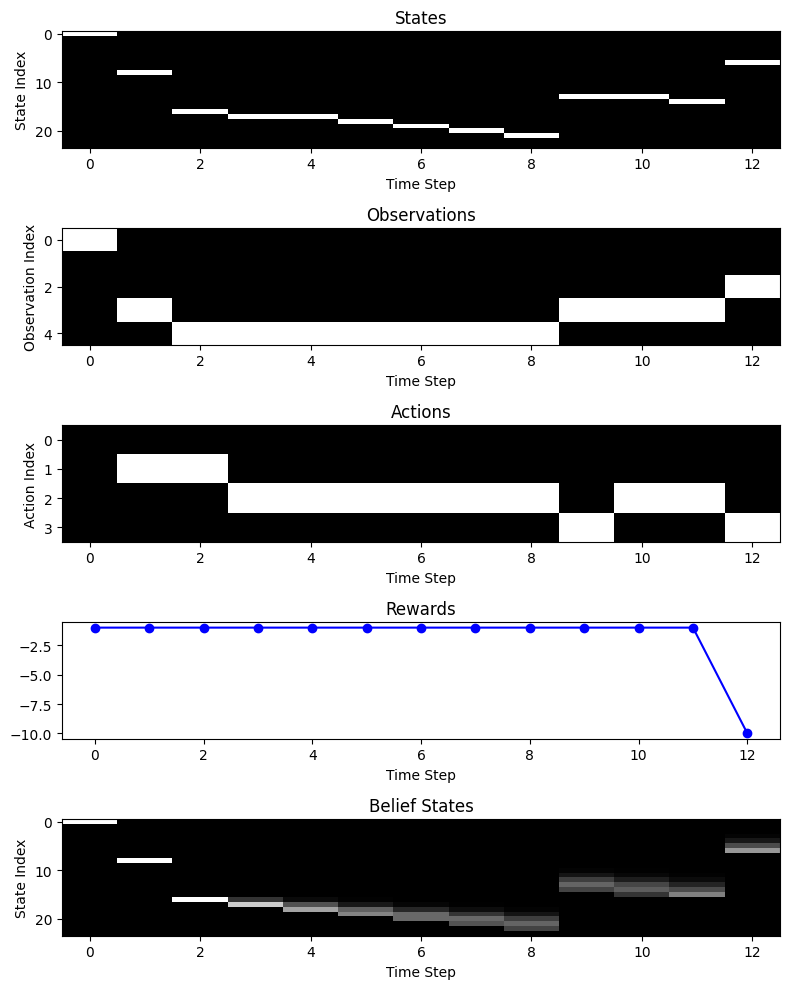

In [5]:
N, M = 3, 8
cliff = CliffWalk(n=N, m=M, self_transition_prob=0.2, gamma=1.0)
policy = cliff.get_optimal_policy(epsilon=0.3)

episodes = collect_episodes(cliff, policy, num_episodes=50000)
history_dim = episodes[0].history.shape[1]  # Number of features in the history (observations + actions)

print("Empirical Value function:")
value_empirical = monte_carlo_state_values(episodes, gamma=cliff.gamma)
print(np.flip(value_empirical.reshape((cliff.n, cliff.m)), axis=0))

test_episode = collect_episodes(cliff, policy, num_episodes=1)[0]
#test_episode = episodes[0]
test_episode.render()

## Train Model

True Values:
[-18.34 -17.55 -18.93 -17.65 -16.38 -15.11 -13.77 -12.41 -10.88  -9.96  -7.88  -5.89 -10.  ]
Predicted Values:
[0.08 0.08 0.08 0.09 0.1  0.1  0.11 0.11 0.11 0.1  0.11 0.11 0.1 ]


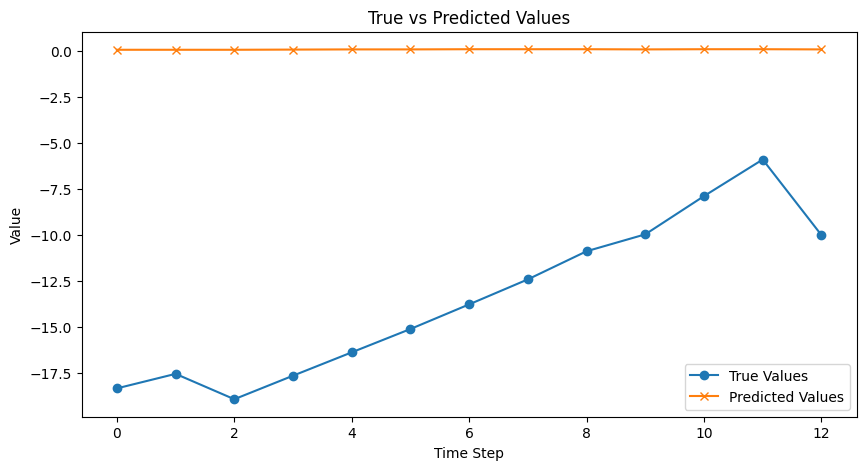

Saved checkpoint: checkpoints/checkpoint_epoch_0.pth
Epoch 50, TD Loss: 2.4541, MC Loss: 12.7786, Total: 13.0121     
Epoch 100, TD Loss: 2.6279, MC Loss: 10.7044, Total: 11.0223     
Epoch 150, TD Loss: 2.8702, MC Loss: 2.6799, Total: 3.9268       
Epoch 200, TD Loss: 2.5418, MC Loss: 0.9058, Total: 2.6983     
Epoch 250, TD Loss: 2.4419, MC Loss: 0.7327, Total: 2.5495     
Epoch 300, TD Loss: 2.3050, MC Loss: 0.7991, Total: 2.4396     
Epoch 350, TD Loss: 2.0176, MC Loss: 0.8013, Total: 2.1709     
Epoch 400, TD Loss: 1.7698, MC Loss: 0.4233, Total: 1.8197     
Epoch 450, TD Loss: 1.7556, MC Loss: 0.2861, Total: 1.7788     
Epoch 500, TD Loss: 1.9463, MC Loss: 0.4084, Total: 1.9887     
True Values:
[-18.34 -17.55 -18.93 -17.65 -16.38 -15.11 -13.77 -12.41 -10.88  -9.96  -7.88  -5.89 -10.  ]
Predicted Values:
[-18.27 -16.73 -16.86 -14.77 -14.07 -13.26 -12.72 -12.22 -11.82  -9.27  -8.65  -8.83 -10.23]


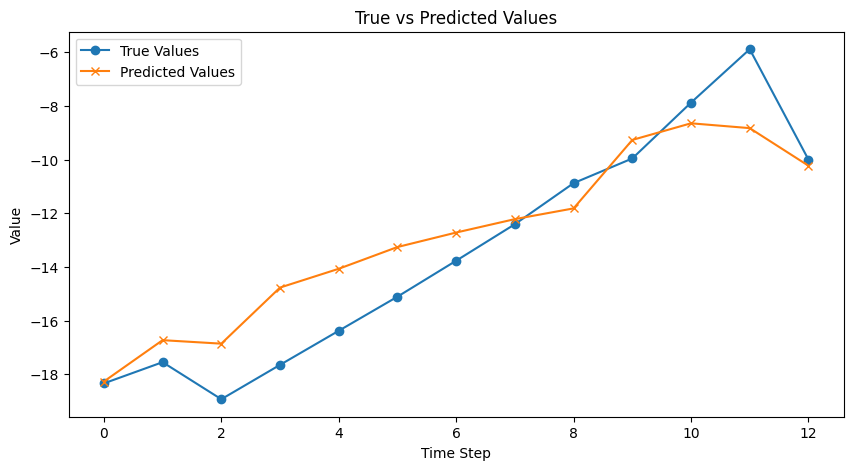

Saved checkpoint: checkpoints/checkpoint_epoch_500.pth
Epoch 550, TD Loss: 1.9971, MC Loss: 0.4514, Total: 2.0475     
Epoch 600, TD Loss: 1.9053, MC Loss: 0.4377, Total: 1.9549     
Epoch 650, TD Loss: 1.8034, MC Loss: 0.4092, Total: 1.8492     
Epoch 700, TD Loss: 1.7846, MC Loss: 0.2333, Total: 1.7997     
Epoch 750, TD Loss: 1.7278, MC Loss: 0.2519, Total: 1.7460     
Epoch 800, TD Loss: 1.8058, MC Loss: 0.4889, Total: 1.8708     
Epoch 850, TD Loss: 1.8364, MC Loss: 0.5035, Total: 1.9041     
Epoch 900, TD Loss: 2.1522, MC Loss: 0.2879, Total: 2.1714     
Epoch 950, TD Loss: 1.9695, MC Loss: 0.1968, Total: 1.9793     
Epoch 1000, TD Loss: 1.7616, MC Loss: 0.3063, Total: 1.7881     
True Values:
[-18.34 -17.55 -18.93 -17.65 -16.38 -15.11 -13.77 -12.41 -10.88  -9.96  -7.88  -5.89 -10.  ]
Predicted Values:
[-18.1  -16.6  -17.31 -16.58 -15.81 -15.03 -14.29 -13.61 -13.01  -9.87  -9.78  -9.56 -10.44]


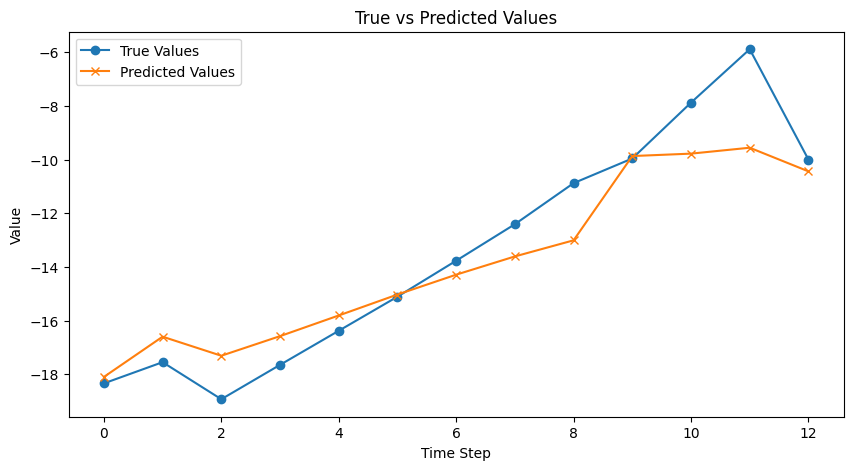

Saved checkpoint: checkpoints/checkpoint_epoch_1000.pth
Epoch 1050, TD Loss: 1.6074, MC Loss: 0.3365, Total: 1.6422     
Epoch 1100, TD Loss: 1.5741, MC Loss: 0.2395, Total: 1.5922     
Epoch 1150, TD Loss: 1.5662, MC Loss: 0.2386, Total: 1.5842     
Epoch 1200, TD Loss: 1.6187, MC Loss: 0.3456, Total: 1.6552     
Epoch 1250, TD Loss: 1.7938, MC Loss: 0.2429, Total: 1.8102     
Epoch 1300, TD Loss: 1.7636, MC Loss: 0.2302, Total: 1.7786     
Epoch 1350, TD Loss: 1.5937, MC Loss: 0.2689, Total: 1.6162     
Epoch 1400, TD Loss: 1.5597, MC Loss: 0.2549, Total: 1.5804     
Epoch 1450, TD Loss: 1.5075, MC Loss: 0.1323, Total: 1.5133     
Epoch 1500, TD Loss: 1.5654, MC Loss: 0.3025, Total: 1.5944     
True Values:
[-18.34 -17.55 -18.93 -17.65 -16.38 -15.11 -13.77 -12.41 -10.88  -9.96  -7.88  -5.89 -10.  ]
Predicted Values:
[-18.44 -18.25 -19.07 -17.79 -16.59 -15.27 -13.84 -12.4  -11.08  -7.71  -6.96  -6.44  -9.3 ]


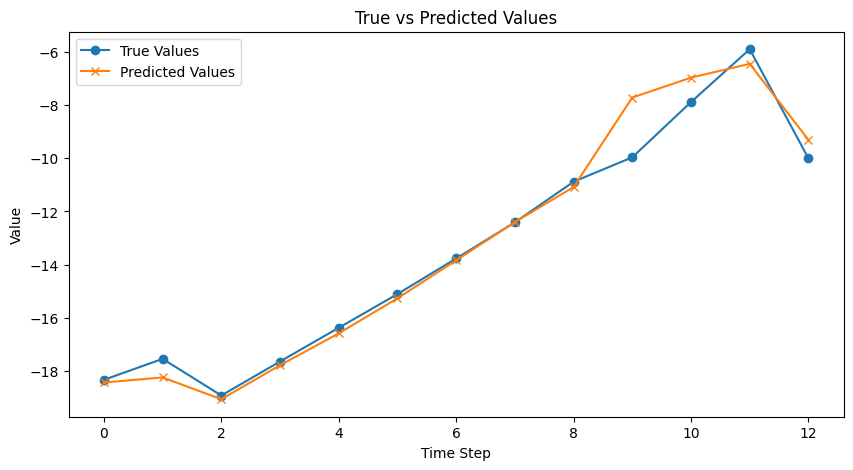

Saved checkpoint: checkpoints/checkpoint_epoch_1500.pth
Epoch 1550, TD Loss: 1.7446, MC Loss: 0.1805, Total: 1.7539     
Epoch 1600, TD Loss: 1.6402, MC Loss: 0.1674, Total: 1.6488     
Epoch 1650, TD Loss: 1.5180, MC Loss: 0.2565, Total: 1.5395     
Epoch 1700, TD Loss: 1.5219, MC Loss: 0.1340, Total: 1.5278     
Epoch 1750, TD Loss: 1.5327, MC Loss: 0.2347, Total: 1.5506     
Epoch 1800, TD Loss: 1.6524, MC Loss: 0.2195, Total: 1.6669     
Epoch 1850, TD Loss: 1.6232, MC Loss: 0.1242, Total: 1.6279     
Epoch 1900, TD Loss: 1.5096, MC Loss: 0.2550, Total: 1.5310     
Epoch 1950, TD Loss: 1.5020, MC Loss: 0.0970, Total: 1.5051     
Epoch 2000, TD Loss: 1.5015, MC Loss: 0.2003, Total: 1.5148     
True Values:
[-18.34 -17.55 -18.93 -17.65 -16.38 -15.11 -13.77 -12.41 -10.88  -9.96  -7.88  -5.89 -10.  ]
Predicted Values:
[-18.37 -17.85 -18.64 -17.33 -16.07 -14.73 -13.24 -11.69 -10.19  -7.3   -6.16  -5.47  -9.5 ]


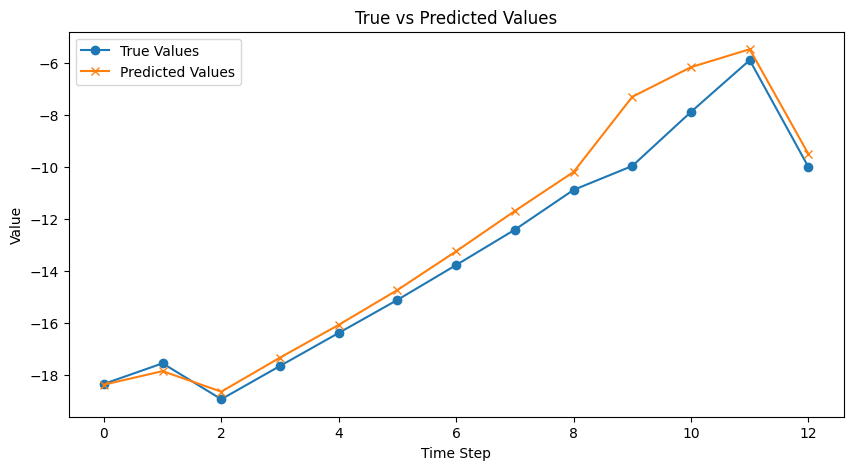

Saved checkpoint: checkpoints/checkpoint_epoch_2000.pth


In [6]:
value_RNN = ValueRNN(input_dim=history_dim, hidden_dim=64)

train(value_RNN, episodes, test_episode, value_empirical, num_epochs=2001, gamma=1.0, lr=1e-3, validate_every=500, batch_size=2500)

## Decode Belief State

In [7]:
def estimate_entropy(belief_states, base=np.e):
    eps = 1e-12  # prevent log(0)
    belief_states = np.clip(belief_states, eps, 1.0)
    log_fn = np.log if base == np.e else lambda x: np.log2(x) if base == 2 else lambda x: np.log(x) / np.log(base)
    
    entropies = -np.sum(belief_states * log_fn(belief_states), axis=1)
    return np.round(np.mean(entropies),4)

all_belief_states = []
for episode in episodes:
    all_belief_states.append(np.array(episode.belief_states))
all_belief_states = np.concatenate(all_belief_states, axis=0)
average_entropy = estimate_entropy(all_belief_states, base=np.e)

print("Average Entropy of Belief States:", average_entropy)

Average Entropy of Belief States: 0.7897


Validating Value RNN at epoch 0:


/tmp/ipykernel_185999/3642384196.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{epoch}.pth")


Estimated KL Divergence Loss: 0.1912809
Belief Decoder:


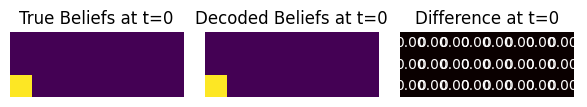

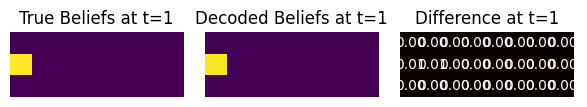

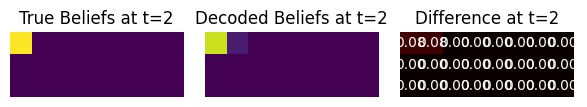

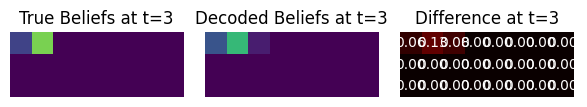

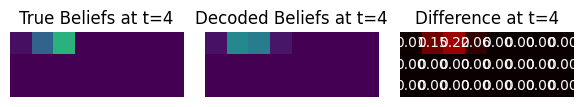

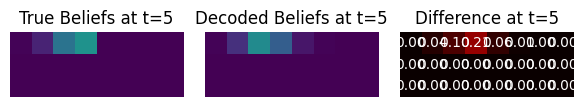

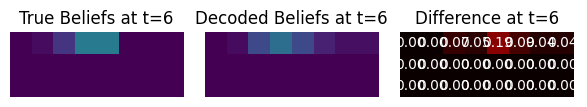

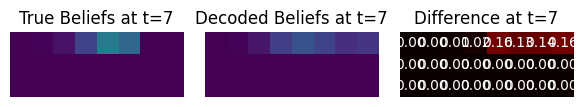

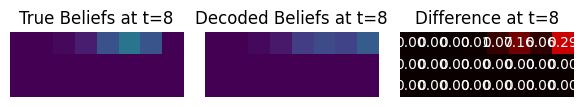

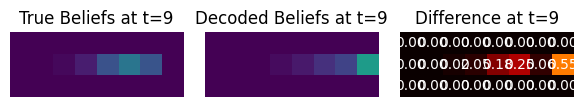

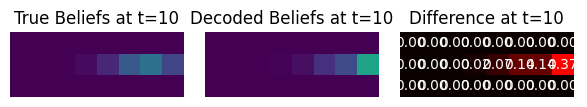

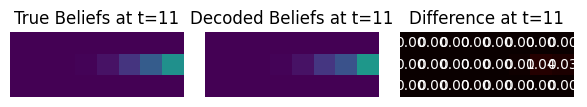

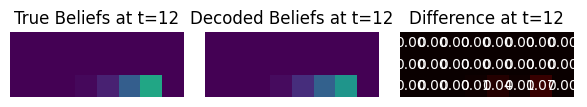

Validating Value RNN at epoch 500:
Estimated KL Divergence Loss: 0.1554451
Belief Decoder:


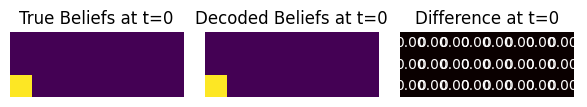

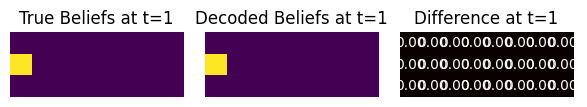

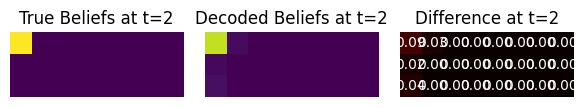

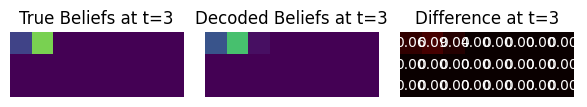

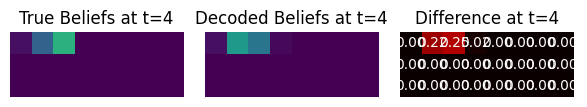

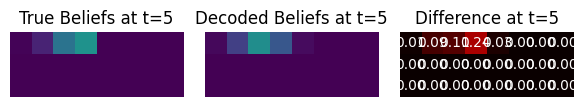

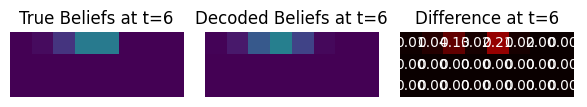

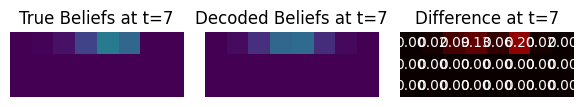

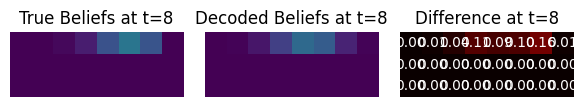

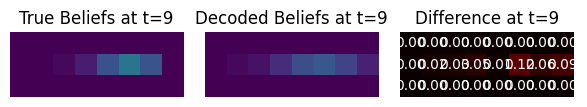

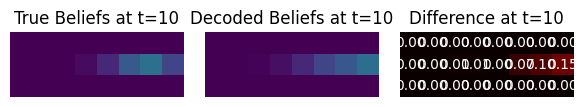

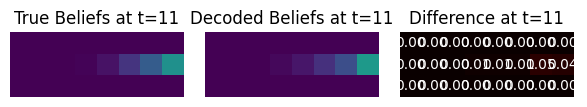

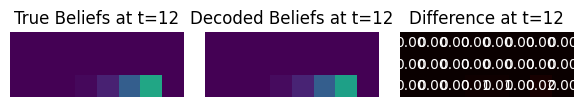

Validating Value RNN at epoch 1000:
Estimated KL Divergence Loss: 0.0859756
Belief Decoder:


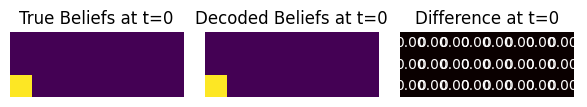

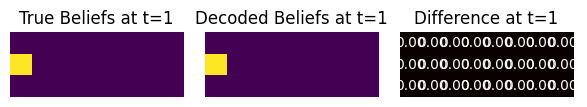

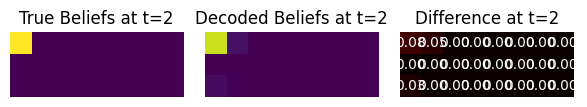

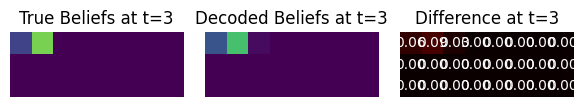

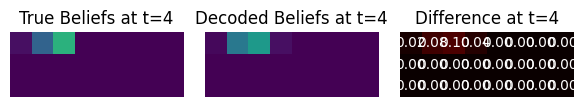

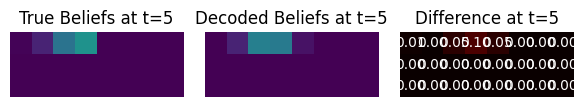

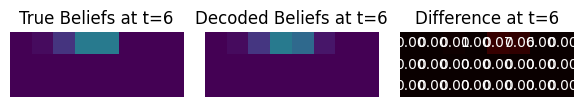

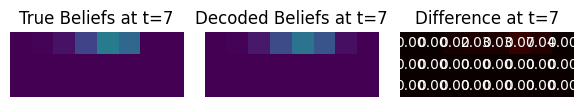

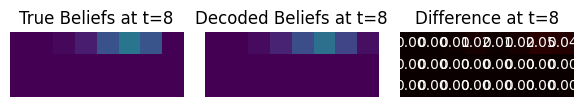

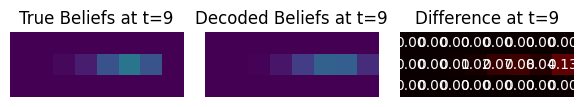

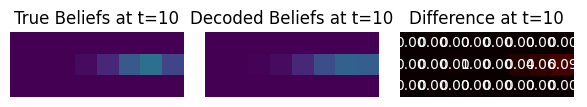

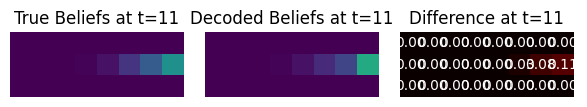

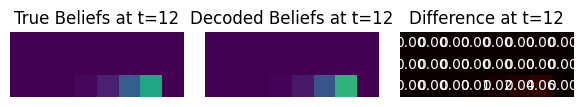

Validating Value RNN at epoch 1500:
Estimated KL Divergence Loss: 0.0484381
Belief Decoder:


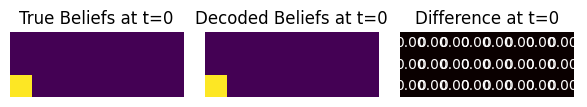

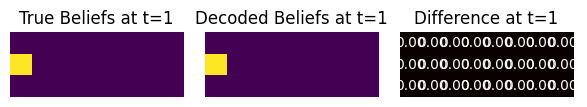

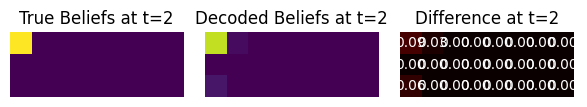

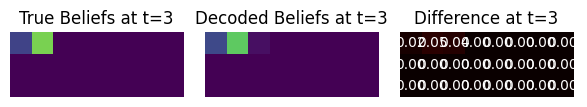

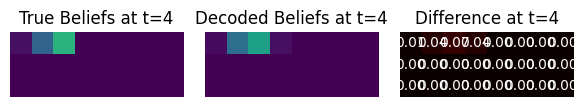

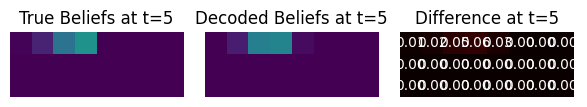

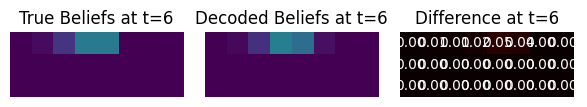

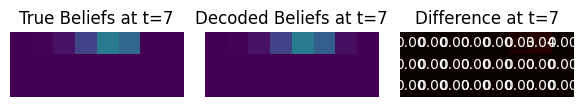

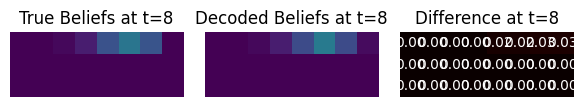

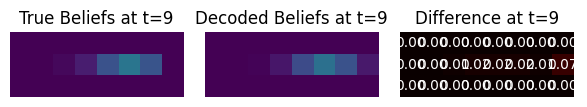

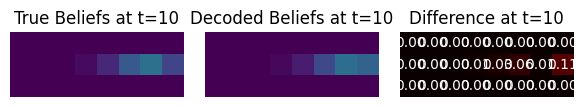

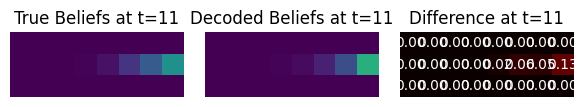

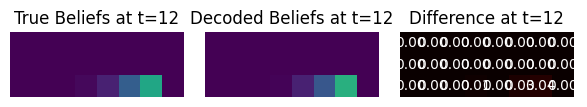

Validating Value RNN at epoch 2000:
Estimated KL Divergence Loss: 0.0321218
Belief Decoder:


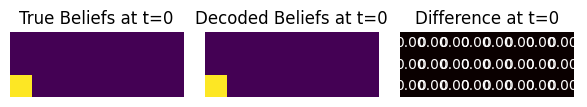

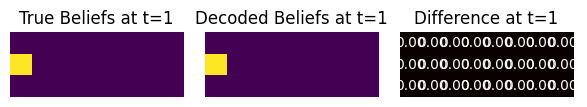

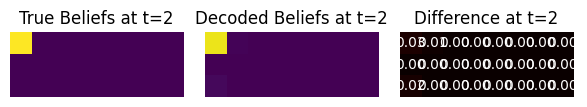

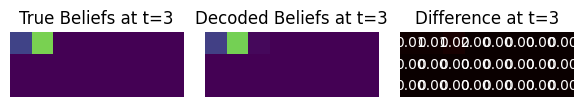

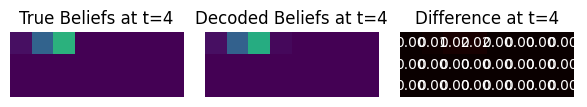

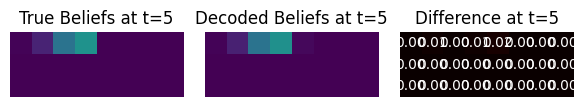

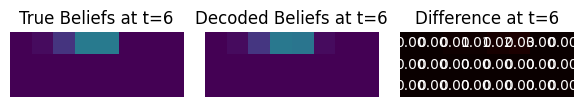

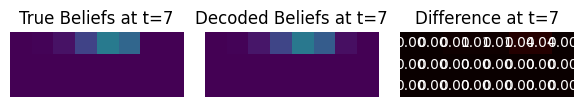

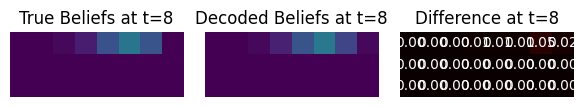

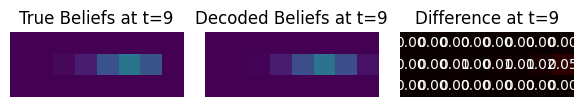

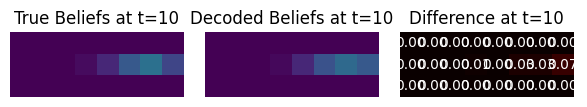

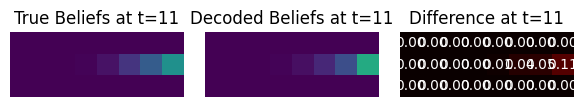

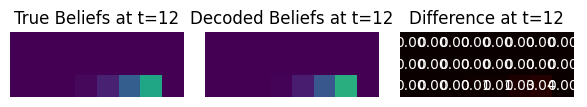

In [10]:
for epoch in [0, 500, 1000, 1500, 2000]:
    print(f"Validating Value RNN at epoch {epoch}:")
    
    checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{epoch}.pth")
    value_RNN.load_state_dict(checkpoint['model_state_dict'])

    belief_decoder = BeliefDecoder(input_dim=64, hidden_dim=64, belief_dim=cliff.n * cliff.m)
    loss = train_belief_decoder(belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)
    print("Estimated KL Divergence Loss:", np.round(loss - average_entropy, 4))

    print("Belief Decoder:")
    plot_decoded_belief(value_RNN, belief_decoder, test_episode, (N, M))

Validating Value RNN at epoch 0:


/tmp/ipykernel_185999/2560840319.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{epoch}.pth")


Estimated KL Divergence Loss: 1.1469357
Belief Decoder:


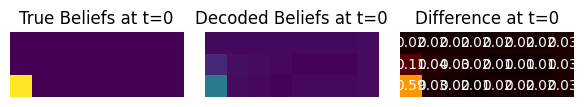

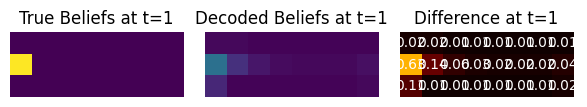

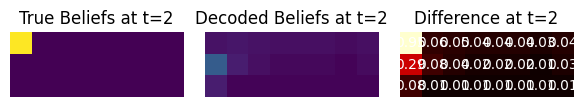

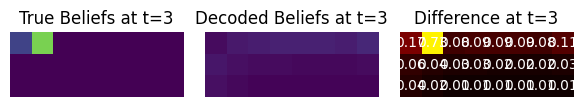

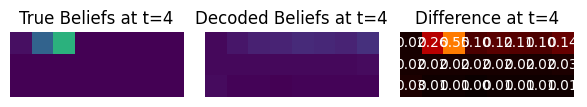

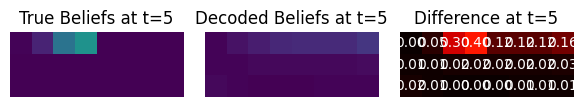

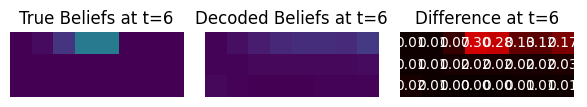

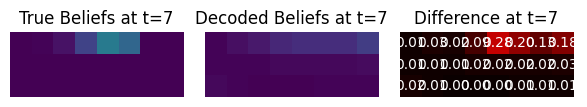

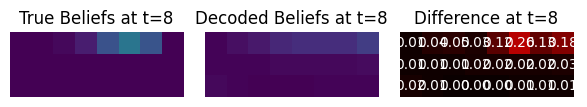

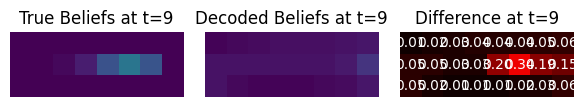

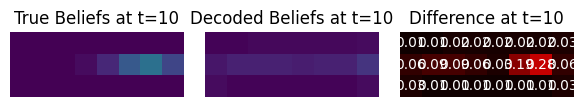

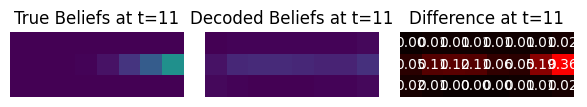

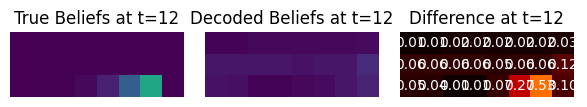

Validating Value RNN at epoch 500:
Estimated KL Divergence Loss: 0.6488385
Belief Decoder:


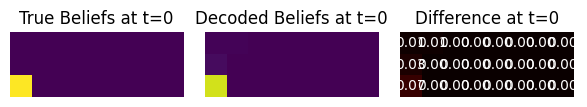

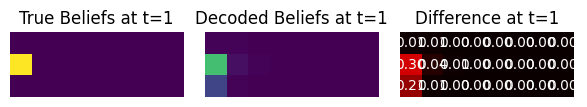

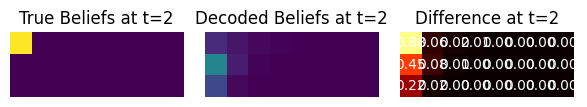

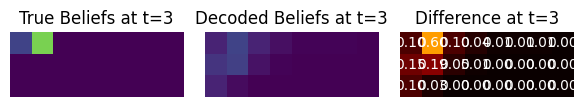

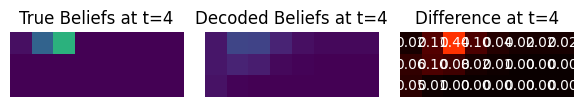

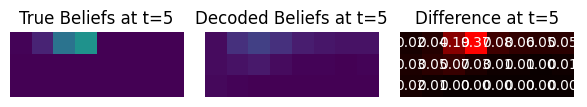

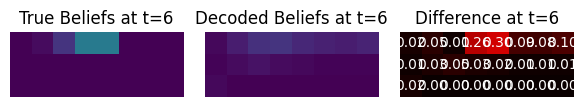

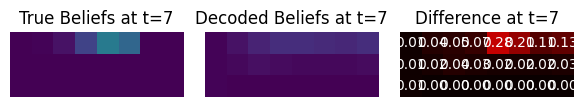

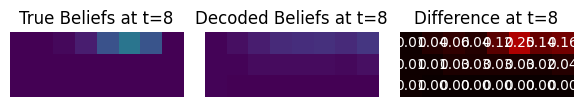

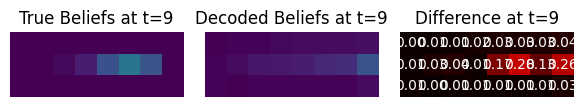

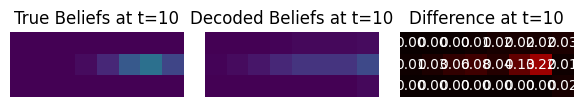

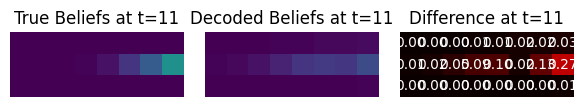

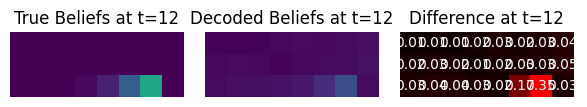

Validating Value RNN at epoch 1000:
Estimated KL Divergence Loss: 0.5553447
Belief Decoder:


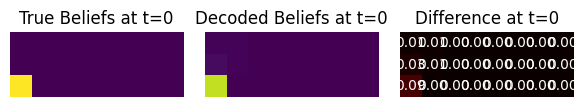

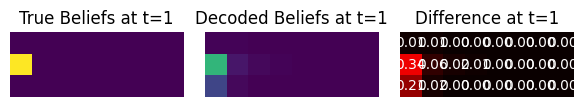

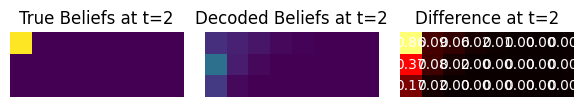

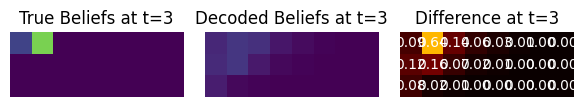

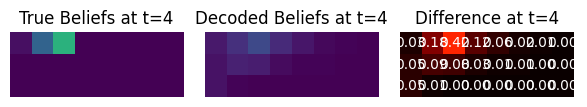

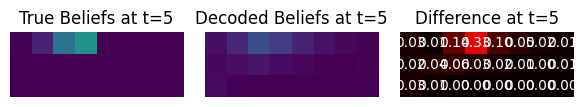

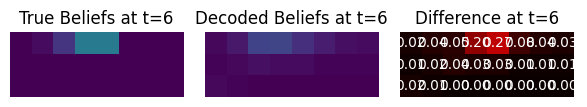

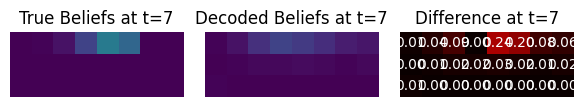

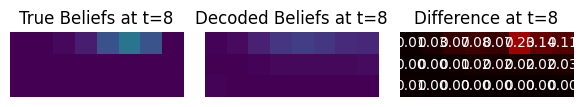

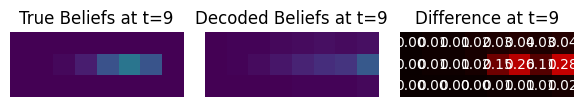

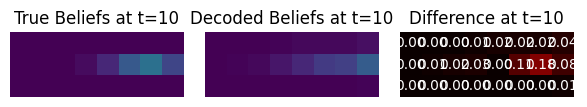

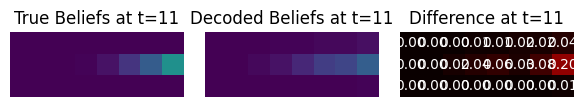

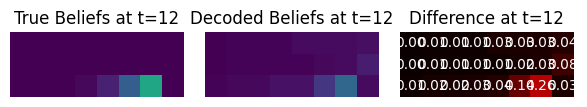

Validating Value RNN at epoch 1500:
Estimated KL Divergence Loss: 0.4529426
Belief Decoder:


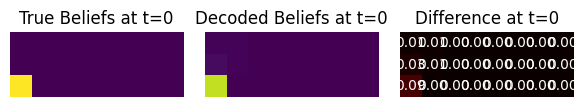

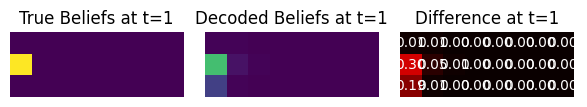

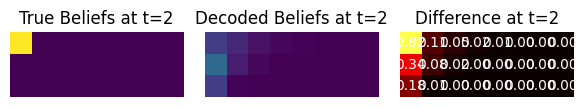

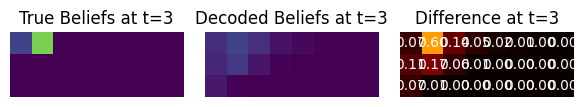

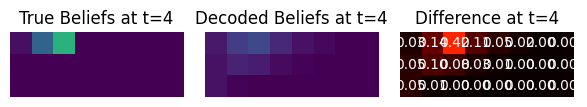

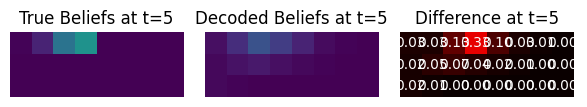

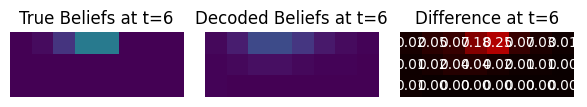

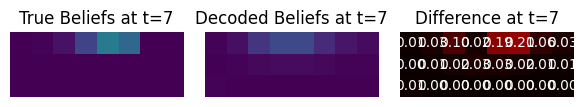

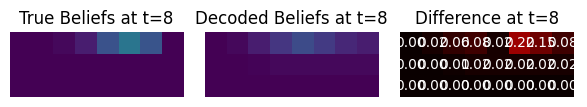

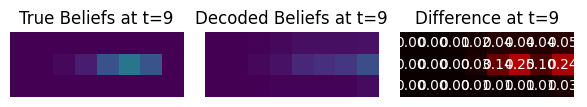

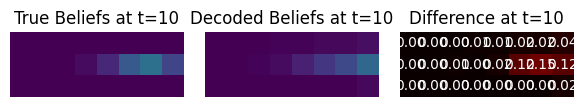

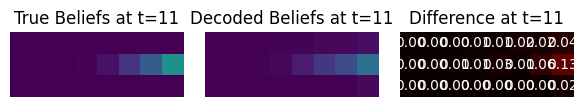

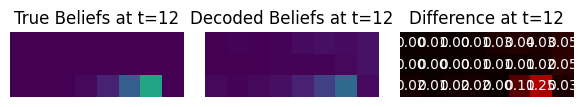

Validating Value RNN at epoch 2000:
Estimated KL Divergence Loss: 0.4529426
Belief Decoder:


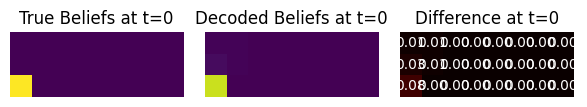

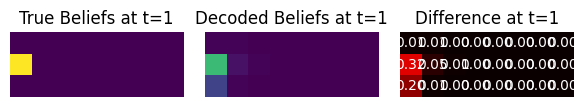

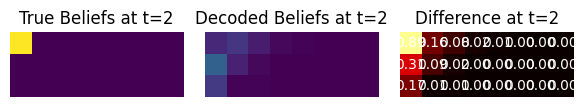

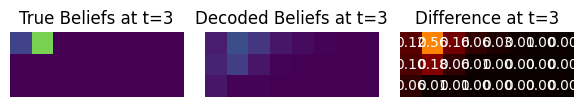

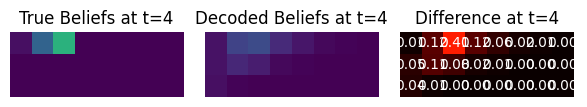

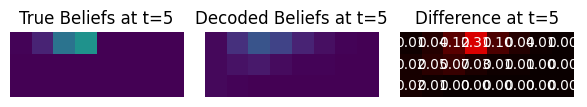

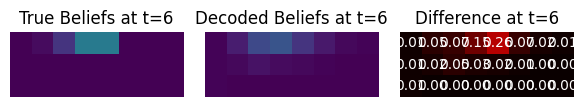

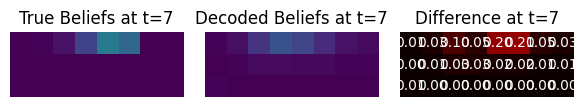

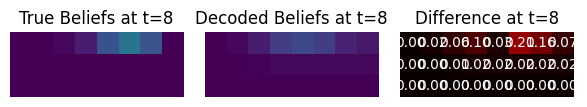

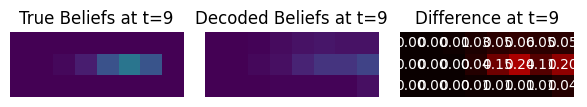

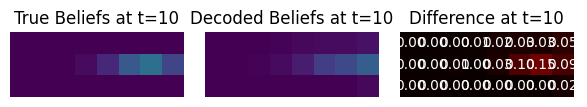

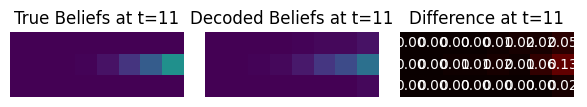

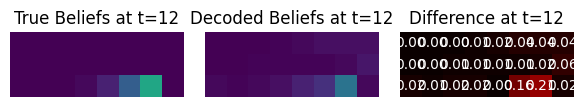

In [11]:
for epoch in [0, 500, 1000, 1500, 2000]:
    print(f"Validating Value RNN at epoch {epoch}:")
    
    checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{epoch}.pth")
    value_RNN.load_state_dict(checkpoint['model_state_dict'])

    belief_decoder = linearBeliefDecoder(input_dim=64, belief_dim=cliff.n * cliff.m)
    loss = train_belief_decoder(belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)
    print("Estimated KL Divergence Loss:", np.round(loss - average_entropy, 4))

    print("Belief Decoder:")
    plot_decoded_belief(value_RNN, belief_decoder, test_episode, (N, M))